In [1]:
# Downlaoding data in Colab

from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='1ZKrbsUlrsTgJSlFMz2EGmTINFCQ8PcjO',dest_path='content/concrete_crack_data.zip',
unzip=True)

Unzipping...Done.


In [2]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras import applications
from keras.applications import Xception
from keras.models import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [3]:
# Preprocessing and loading training data
data = []
img_size=80
def create_data():
  for item in tqdm(['Negative','Positive']):
    path = '/content/content/concrete_cracked_images/train/'+item+"/"
    for img in tqdm(os.listdir(path)):
      try:
        img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_COLOR)
        new_img_array = cv2.resize(img_array,(img_size,img_size))
        if item == 'Negative':
          data.append([new_img_array,0])
        else:
          data.append([new_img_array,1])
      except Exception as e:
        pass

create_data()

100%|██████████| 2/2 [00:21<00:00, 10.68s/it]


In [4]:
# Total number of images in Training data
print("Total number of Training images are: {}".format(len(data)))

Total number of Training images are: 28718


In [5]:
# Seperating images and labels

x = []
y = []
for image in data:
  x.append(image[0])
  y.append(image[1])

# Converting into float array
x = np.array(x,np.float32)/255 # Performing Scaling
y = np.array(y)


In [ ]:
np.unique(y,return_counts=True)

(array([0, 1]), array([13818, 14900]))

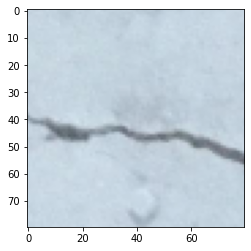

In [ ]:
#Visualizing Image
index =20000
plt.imshow(x[index])

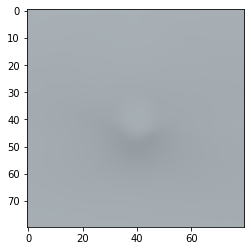

In [6]:
# Performing Standardization on training set
mean_img = np.mean(x,axis=0)
plt.imshow(mean_img)

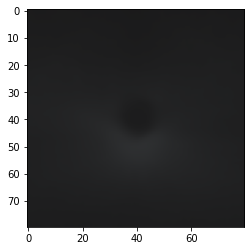

In [7]:
# Caculating the std 
std_img = np.std(x,axis=0)
plt.imshow(std_img)

In [8]:
# Normalizing the image data x
x = (x-mean_img) / std_img

In [9]:
# Splitting the data into train and validation set
X_train, X_val, y_train, y_val = train_test_split(x,y,test_size=0.2, random_state = 42,stratify=y,shuffle=True)

In [10]:
# Data Augumentation
train_datagen = ImageDataGenerator(
        rotation_range=30, 
        width_shift_range=0.1, 
        height_shift_range=0.1,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
train_datagen.fit(X_train)

In [21]:
#Base Model
import keras
base_model = keras.applications.VGG16(include_top=False,weights='imagenet',input_shape=(img_size,img_size,3))
add_model = Sequential()
add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
add_model.add(Dropout(0.45))
add_model.add(Dense(532,activation='relu'))
add_model.add(Dropout(0.45))
add_model.add(Dense(1,activation='sigmoid'))
model = Model(inputs=base_model.input,outputs = add_model(base_model.output))
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=1e-5), metrics=['accuracy'])
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 80, 80, 3)]  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 39, 39, 32)   864         input_5[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 39, 39, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 39, 39, 32)   0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [22]:
training = model.fit(train_datagen.flow(X_train, y_train,batch_size=64),epochs=10,validation_data=(X_val,y_val),verbose=1)

Epoch 1/10
359/359 [==============================] - 70s 181ms/step - loss: 0.4128 - accuracy: 0.8555 - val_loss: 0.0360 - val_accuracy: 0.9936
Epoch 2/10
359/359 [==============================] - 64s 177ms/step - loss: 0.0481 - accuracy: 0.9880 - val_loss: 0.0151 - val_accuracy: 0.9946
Epoch 3/10
359/359 [==============================] - 64s 178ms/step - loss: 0.0201 - accuracy: 0.9937 - val_loss: 0.0123 - val_accuracy: 0.9958
Epoch 4/10
359/359 [==============================] - 64s 179ms/step - loss: 0.0175 - accuracy: 0.9948 - val_loss: 0.0082 - val_accuracy: 0.9976
Epoch 5/10
359/359 [==============================] - 64s 179ms/step - loss: 0.0155 - accuracy: 0.9957 - val_loss: 0.0135 - val_accuracy: 0.9965
Epoch 6/10
359/359 [==============================] - 64s 178ms/step - loss: 0.0126 - accuracy: 0.9960 - val_loss: 0.0094 - val_accuracy: 0.9972
Epoch 7/10
359/359 [==============================] - 64s 179ms/step - loss: 0.0099 - accuracy: 0.9971 - val_loss: 0.0144 - val_ac

In [ ]:
# Hyper-parameter tuning pre-trained Network
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import  HyperParameters
import keras
base_model = keras.applications.VGG16(include_top=False,weights='imagenet',input_shape=(img_size,img_size,3))
def build(hp):

  add_model = Sequential()
  add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
  add_model.add(Dropout(rate=hp.Float(
                'dropout_1',
                min_value=0.45,
                max_value=0.55,
                default=0.45,
                step=0.05,)))
  add_model.add(Dense(
          units=hp.Int(
                    'units',
                    min_value=128,
                    max_value=512,
                    step=32,
                    default=128),activation='relu'))
  add_model.add(Dropout(rate=hp.Float('dropout_2',
                min_value=0.45,
                max_value=0.55,
                default=0.45,
                step=0.05)))
 
  add_model.add(Dense(1,activation='sigmoid'))
  model = Model(inputs=base_model.input,outputs = add_model(base_model.output))
  model.compile(optimizer=keras.optimizers.Adam(hp.Float(
                    'learning_rate',
                    min_value=1e-5,
                    max_value=1e-4,
                    sampling='LOG',
                    default=1e-5
                )),
                loss=keras.losses.BinaryCrossentropy(),metrics=['accuracy'])
  return model

SEED=1
tuner_search=RandomSearch(build,objective='val_accuracy',seed=SEED,max_trials=3,directory='output',executions_per_trial=1,project_name='Cracks Classification')
history = tuner_search.search(train_datagen.flow(X_train, y_train,batch_size=16),epochs=8,validation_data=(X_val,y_val),verbose=1)

Trial 3 Complete [00h 09m 40s]
val_accuracy: 0.9993036389350891

Best val_accuracy So Far: 0.9993036389350891
Total elapsed time: 00h 29m 21s
INFO:tensorflow:Oracle triggered exit


In [ ]:
#Selecting the best model
best_model = tuner_search.get_best_models(num_models=1)[0]  #99.93% validation accuracy

In [ ]:
# Predict the output for testing data
test_image_order = pd.read_csv("/content/content/concrete_cracked_images/Testing_set_concrete_crack.csv")
test_image_order.head()


,filename
0,Image_1.jpg
1,Image_2.jpg
2,Image_3.jpg
3,Image_4.jpg
4,Image_5.jpg


In [ ]:
#Getting Images File Path

file_paths = [[fname,'/content/content/concrete_cracked_images/test/'+fname]for fname in test_image_order['filename']]

In [ ]:
# Confirm no. of images in test folder == Testing_set_face_mask.csv

if(len(test_image_order)== len(file_paths)):
  print('Number of Image Names :',len(test_image_order),'matches the image path',len(file_paths))
else:
  print('Number of image names does not match the number of filepaths')

Number of Image Names : 11282 matches the image path 11282


In [ ]:
#Converting File path to DataFrame
test_images = pd.DataFrame(file_paths, columns=['filename', 'filepaths'])
test_images.head()

,filename,filepaths
0,Image_1.jpg,/content/content/concrete_cracked_images/test/...
1,Image_2.jpg,/content/content/concrete_cracked_images/test/...
2,Image_3.jpg,/content/content/concrete_cracked_images/test/...
3,Image_4.jpg,/content/content/concrete_cracked_images/test/...
4,Image_5.jpg,/content/content/concrete_cracked_images/test/...


In [ ]:
# Performing Data Preprocessing on test set

test_pixel_data = []
image_size = 80
for i in tqdm(range(len(test_images))):
  img_array = cv2.imread(test_images['filepaths'][i], cv2.IMREAD_COLOR)
  new_img_array = cv2.resize(img_array, (image_size, image_size))
  test_pixel_data.append(new_img_array)

100%|██████████| 11282/11282 [00:10<00:00, 1069.12it/s]


In [ ]:
# Converting into array
test_pixel_data = np.array(test_pixel_data)/255 #scaling

In [ ]:
#Standardizing test data
mean_img_test = np.mean(test_pixel_data,axis=0)
std_img_test = np.std(test_pixel_data,axis=0)
test_pixel_data = (test_pixel_data-mean_img_test) / std_img_test

In [ ]:
# Making predictions on test data

pred = best_model.predict(test_pixel_data)
pred[0]

array([4.2750695e-08], dtype=float32)

In [ ]:
# Converting predictions to desired format

predictions =[]
for value in pred:
  if value <0.5:
     predictions.append("Negative")
  else:
     predictions.append("Positive")


In [ ]:
# Saving to Local storage Disk
filename = "submission.csv"
res = pd.DataFrame({'prediction': predictions}) 
res.to_csv(filename, index = False)